In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as scio
from NeuroRobot.Sim import *
from NeuroRobot.GA import *
from NeuroRobot.Controller import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
file = '\exp\23.04.15.csv'

    Fitness        g0        g1        g2        g3        g4        g5  \
0  0.064920 -0.602399 -0.534713  0.049878  0.131440 -0.625856 -0.513670   
4  0.057536  0.068691 -0.555462 -0.154072 -0.858873  0.802359 -0.642093   
2  0.023101  0.676804 -0.948417  0.323776 -0.617947 -0.592747 -0.012156   
1  0.002542 -0.749700  0.328525  0.917866  0.629954 -0.206104  0.657795   
6  0.002104  0.425863 -0.929945  0.862713 -0.875759  0.358368  0.802637   
8 -0.007658 -0.877040  0.736027 -0.891906  0.419046 -0.418399 -0.834600   
5 -0.018193 -0.254146  0.874092  0.765640  0.618009 -0.472923  0.487885   
9 -0.019030 -0.175726  0.573802 -0.726695  0.270668 -0.993754  0.772642   
3 -0.020896  0.945741 -0.027075  0.102636  0.577604  0.937496 -0.511396   
7 -0.025867 -0.261504  0.495447 -0.407972 -0.801302  0.317620  0.930691   

         g6        g7        g8        g9       g10       g11       g12  \
0  0.805381 -0.225669 -0.851550  0.874614 -0.262474  0.515708 -0.389129   
4  0.219495  0.362249  0

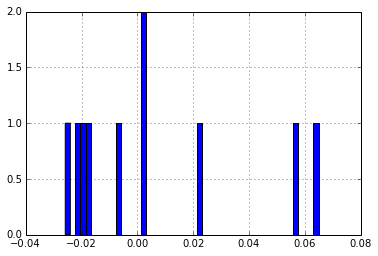

In [3]:
def getBestGenotypeFromFile(file):
    alldata = pd.read_csv(file)
    nCol = alldata.shape[1]
    colList = ['Fitness']
    colList.extend(["g"+str(i) for i in range(0,nCol-1)])
    alldata.columns = colList
    return alldata.sort('Fitness',ascending=False).T.iloc[1:,0].values

alldata = pd.read_csv(file)
nCol = alldata.shape[1]
colList = ['Fitness']
colList.extend(["g"+str(i) for i in range(0,nCol-1)])
alldata.columns = colList
alldata['Fitness'].hist(bins=50)
print(alldata.sort('Fitness',ascending=False))
genes=alldata.sort('Fitness',ascending=False).T.iloc[1:,0].values

print(genes)


In [4]:
from NeuroRobot.Sim import *
#from NeuroRobot.Visualiser import *
from NeuroRobot.GA import *
from NeuroRobot.Controller import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,gridspec
from collections import deque
import itertools

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

animation.Animation._repr_html_ = anim_to_html

class LiveSinglePlot():
    def __init__(self,subplot_spec,nLines=1,ylim=(-0.1,1.1),xsize=30,title='',xlabel='',ylabel=''):
        self.xsize = xsize
        self.nLines = nLines
        self.dataQs = []
        
        self.ax = plt.subplot(subplot_spec,ylim=ylim)
        self.ax.set_title(title)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        
        for i in range(0,nLines):
            q = deque(maxlen=xsize)
            for j in range(0,xsize):
                q.append(0)
            self.dataQs.append(q)
        
        self.ax.plot(np.arange(0,xsize),np.zeros(xsize))
        self.ax.plot(np.arange(0,xsize),np.zeros(xsize))
    
    def update(self,new_data):
        if(len(new_data) != self.nLines):
            raise ValueError('Data was length %d, must be same as number of lines(%d)' % (len(new_data),self.nLines))
        
        for line,q,datum in zip(self.ax.get_lines(),self.dataQs,new_data):
            q.append(datum)
            line.set_data(np.arange(0,self.xsize),np.array(q))
        

class LiveMultiPlot():
    def __init__(self,n,subplot_spec,ylim=(-0.1,1.1),xsize=30,ylabels=None,title='',xlabel='',ylabel=''):
        self.xsize = xsize
        self.n = n
        self.dataQs = []
        self.axes = []
        
        gs = gridspec.GridSpecFromSubplotSpec(n,1,subplot_spec)
        
        if(ylabels is None):
            ylabels = range(1,n+1)
        
        for i in range(0,n):
            q = deque(maxlen=xsize)
            for j in range(0,xsize):
                q.append(0)
            self.dataQs.append(q)
        
            if(i > 0):
                ax = plt.subplot(gs[i,0],sharex=self.axes[0])
                ax.spines['top'].set_visible(False)
            else:
                ax = plt.subplot(gs[i,0])
                ax.set_title(title)
            
            self.axes.append(ax)
            
            ax.set_ylabel(ylabels[i])
            ax.set_ylim(ylim[0],ylim[1])
            plt.setp(ax.get_yticklabels(), visible=False)
            
            if(i<n-1):
                ax.spines['bottom'].set_visible(False)
                plt.setp(ax.get_xticklabels(), visible=False)
                
            ax.plot(np.arange(0,xsize),np.zeros(xsize))

        self.axes[-1].set_xlabel(xlabel)
            
    def update(self,new_data):
        if(len(new_data) != self.n):
            raise ValueError('Data was length %d, must be same as number of plots(%d)' % (len(new_data),self.n))
        
        for ax,q,datum in zip(self.axes,self.dataQs,new_data):
            q.append(datum)
            ax.get_lines()[0].set_data(np.arange(0,self.xsize),np.array(q))
        
class AnimatedRobotPlot():
    def __init__(self,trial,inputXSize=30):
        self.trial = trial
        self.inputXSize = inputXSize
        self.fig = plt.figure(figsize=(9,9))
        gs = gridspec.GridSpec(3,2)

        self.init_worldFig(gs[0])
        self.inputPlot=LiveMultiPlot(n=4,subplot_spec=gs[1],ylabels = ('A_L','B_L','A_R','B_R'),title='Inputs',xlabel='Time')
        self.oscPlot=LiveMultiPlot(n=3,subplot_spec=gs[2],ylim=[-1.1,1.1],title='Oscillators',xlabel='Time')
        self.plastPlot=LiveMultiPlot(n=6,subplot_spec=gs[3],ylim=[-0.1,1.1],title='Plasticity',xlabel='Time')
        self.lightsFig=LiveSinglePlot(gs[4],nLines=2,ylim=[0,175],title='Distance to lights',xlabel='Time',ylabel='Distance')
        
        plt.tight_layout()
    
    def init_worldFig(self,subplot_spec):
        axWorld = plt.subplot(subplot_spec,xlim=(-200,200),ylim=(-200,200))
        axWorld.set_title('World')
        axWorld.set_xlabel('X')
        axWorld.set_ylabel('Y')
        scatWorld = axWorld.scatter(0,0,animated=True)

        scatWorld.set_offsets([0,0])
        scatWorld.set_array(np.array([0,0]))
        lA = plt.Circle((self.trial.lightA.position[0],self.trial.lightA.position[1]),5,color='r')
        lB = plt.Circle((self.trial.lightB.position[0],self.trial.lightB.position[1]),5,color='g')
        axWorld.add_patch(lA)
        axWorld.add_patch(lB)

        self.axWorld = axWorld
        self.scatWorld = scatWorld
        
        

    def step(self,i):
        self.trial.robot.step()
        self.scatWorld.set_offsets(np.array(self.trial.robot.position))
        
        nodes = self.trial.robot.controller.nn.nodes
        
        thetas,plasts=[],[]
        for node in self.trial.robot.controller.nn.nodes:
            thetas.append(node.theta)
            plasts.extend([c.getPlasticity() for c in node.couplings])
        
        thetas = [np.sin(node.theta) for node in nodes]
        plasts = [c.getPlasticity() for c in node.couplings for node in nodes]
        
        
        self.inputPlot.update(self.trial.robot.lastInput)
        self.oscPlot.update(thetas)
        self.plastPlot.update(plasts)
        self.lightsFig.update(self.trial.getDists())

In [ ]:
t =Trial(netparams=NetParams(Genotype(genes)),trialtype=TrialType.BOTH_BLINKB)
controller = t.robot.controller        
arp = AnimatedRobotPlot(t)

anim = animation.FuncAnimation(arp.fig,arp.step, frames=1000,interval=100,blit=True)
display_animation(anim)